## <span style='color:#ff5f27'> 📝 Imports

In [ ]:
!pip install -U xgboost --quiet

In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Mute warnings
import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [2]:
import hopsworks
project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/148
Connected. Call `.close()` to terminate connection gracefully.


### <span style="color:#ff5f27;"> 🔪 Feature Selection </span>

You will start by selecting all the features you want to include for model training/inference.

In [3]:
# Retrieve feature groups
trans_fg = fs.get_feature_group(
    name='transactions_fraud_batch_fg', 
    version=1,
)
window_aggs_fg = fs.get_feature_group(
    name='transactions_1h_aggs_fraud_batch_fg', 
    version=1,
)

In [4]:
# Select features for training data.
selected_features = trans_fg.select(["fraud_label", "category", "amount", "age_at_transaction", "days_until_card_expires", "loc_delta"])\
    .join(window_aggs_fg.select_except(["cc_num"]))

In [5]:
selected_features.show(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.37s) 


,fraud_label,category,amount,age_at_transaction,days_until_card_expires,loc_delta,trans_volume_mstd,trans_volume_mavg,trans_freq,loc_delta_mavg,datetime
0,0,Restaurant/Cafeteria,94.39,79,1125,0.000000,0.0,94.39,1.0,0.000000,1641010897000
1,0,Clothing,72.32,79,1125,0.154888,0.0,72.32,1.0,0.154888,1641021603000
2,0,Grocery,84.45,79,1123,0.223899,0.0,84.45,1.0,0.223899,1641194862000
3,0,Grocery,10.08,79,1123,0.265893,0.0,10.08,1.0,0.265893,1641238430000
4,0,Clothing,212.80,79,1122,0.222703,0.0,212.80,1.0,0.222703,1641258676000


Recall that you computed the features in `transactions_1h_aggs_fraud_batch_fg` using 1-hour aggregates. If you had created multiple feature groups with identical schema for different window lengths, and wanted to include them in the join you would need to include a prefix argument in the join to avoid feature name clash. See the [documentation](https://docs.hopsworks.ai/feature-store-api/latest/generated/api/query_api/#join) for more details.

---

### <span style="color:#ff5f27;"> 🤖 Transformation Functions </span>


You will preprocess our data using *min-max scaling* on numerical features and *label encoding* on categorical features. To do this you simply define a mapping between our features and transformation functions. This ensures that transformation functions such as *min-max scaling* are fitted only on the training data (and not the validation/test data), which ensures that there is no data leakage.

In [9]:
# Load transformation functions.
label_encoder = fs.get_transformation_function(name="label_encoder")
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")

# Map features to transformations.
transformation_functions = {
    "category": label_encoder,
    "amount":min_max_scaler,
    "age_at_transaction":min_max_scaler,
    "days_until_card_expires":min_max_scaler,
    "trans_volume_mavg":min_max_scaler
}

## <span style="color:#ff5f27;"> ⚙️ Feature View Creation </span>

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.
In order to create a Feature View you may use `fs.create_feature_view()`. Here we try first to get the feature view, and if we can't an exception is thrown and we create the feature view.

In [11]:
# Get or create the 'transactions_view_fraud_batch_fv' feature view
feature_view = fs.get_or_create_feature_view(
    name='transactions_view_fraud_batch_fv',
    version=1,
    query=selected_features,
    labels=["fraud_label"],
    transformation_functions=transformation_functions,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/148/fs/90/fv/transactions_view_fraud_batch_fv/version/1


## <span style="color:#ff5f27;"> 🏋️ Training Dataset Creation</span>

In Hopsworks training data is a query where the projection (set of features) is determined by the parent FeatureView with an optional snapshot on disk of the data returned by the query.

**Training Dataset  may contain splits such as:** 
* Training set - the subset of training data used to train a model.
* Validation set - the subset of training data used to evaluate hparams when training a model
* Test set - the holdout subset of training data used to evaluate a mode

Training dataset is created using `feature_view.train_validation_test_split()` method.

In [12]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2,)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (7.53s) 
2024-10-23 11:57:12,882 WARNING: VersionWarning: Incremented version to `1`.



In [13]:
# Display the normalized value counts of the y_train Series
y_train.value_counts(normalize=True)

fraud_label
0              0.998537
1              0.001463
Name: proportion, dtype: float64

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus you should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, you will use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

---

## <span style="color:#ff5f27;"> 🧬 Modeling</span>

Next you will train a model. Here, you set larger class weight for the positive class.

In [14]:
# Create an instance of the XGBClassifier
model = xgb.XGBClassifier()

# Fit the classifier on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
# Predict the training data using the trained classifier
y_pred_train = model.predict(X_train)

# Predict the test data using the trained classifier
y_pred_test = model.predict(X_test)

In [16]:
# Compute f1 score
metrics = {
    "f1_score": f1_score(y_test, y_pred_test, average='macro')
}
metrics

{'f1_score': 0.8652178931438685}

In [17]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels (y_pred_test)
results = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print(results)

[[20986     1]
 [   13    19]]


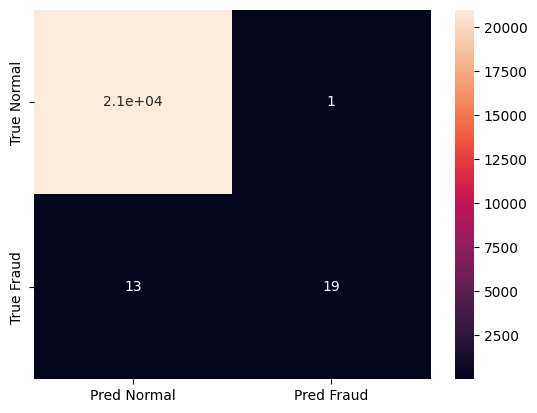

In [18]:
# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    results, 
    ['True Normal', 'True Fraud'],
    ['Pred Normal', 'Pred Fraud'],
)

# Create a heatmap using seaborn with annotations
cm = sns.heatmap(df_cm, annot=True)

# Get the figure from the heatmap and display it
fig = cm.get_figure()
fig.show()

---

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/3.0/user_guides/mlops/registry/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [ ]:
# from hsml.schema import Schema
# from hsml.model_schema import ModelSchema

# # Define the input schema using the values of X_train
# input_schema = Schema(X_train.values)

# # Define the output schema using y_train
# output_schema = Schema(y_train)

# # Create a ModelSchema object specifying the input and output schemas
# model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# # Convert the model schema to a dictionary for further inspection or serialization
# model_schema.to_dict()

## <span style="color:#ff5f27;">📝 Register model</span>

One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [19]:
# Specify the directory where the model will be saved
model_dir = "fraud_batch_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model using joblib
model.save_model(model_dir + "/model.json")

# Save the confusion matrix heatmap as an image in the model directory
fig.savefig(model_dir + "/confusion_matrix.png")

In [21]:
# Get the model registry
mr = project.get_model_registry()

# Create a new model in the model registry
fraud_model = mr.python.create_model(
    name="xgboost_fraud_batch_model",     # Name for the model
    metrics=metrics,                      # Metrics used for evaluation
    description="Fraud Batch Predictor",  # Description of the model
)

# Save the model to the specified directory
fraud_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/19033 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/202415 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/148/models/xgboost_fraud_batch_model/1


Model(name: 'xgboost_fraud_batch_model', version: 1)